In [2]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


In [3]:
import warnings # supress warnings
warnings.filterwarnings('ignore')

os.chdir("")
housing = pd.read_csv('Housing.csv')
# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

In [4]:
# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()
housing = pd.concat([housing, status], axis = 1)
housing.head()
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()
df=housing
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [5]:
# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

In [6]:
df.head()
X = df.drop('price',axis=1)
y = df['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
# predict prices of X_test
y_pred = rfe.predict(X_test)

In [7]:
# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

0.6519767225566988


In [8]:
# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores 
# the other way of doing the same thing (more explicit)

0.6171279856258437


array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [9]:
# create a KFold object with 5 splits 
lm = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores  
scores = cross_val_score(lm, X_train, y_train, scoring='mean_squared_error', cv=5)
scores
#Grid Search CV
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)


In [10]:
# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': np.arange(1,14)}]
#hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)   

In [11]:
# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  
print(model_cv.best_score_)
print(model_cv.best_estimator_)
print(model_cv.best_params_)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
plt.figure(figsize=(16,6))

Fitting 5 folds for each of 13 candidates, totalling 65 fits
0.6366901953006314
RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=12, step=1, verbose=0)
{'n_features_to_select': 12}


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.5s finished


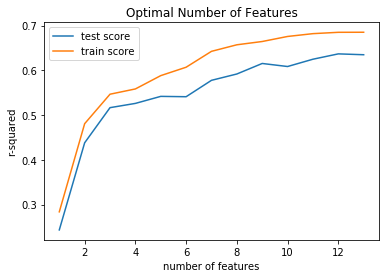

In [12]:
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')